In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

path = '../caliper-benchmarks/reports'
# files = [f for f in listdir(path) if '.html' in f]
sendrates = np.arange(40,240,40)
frames_all = []
for rate in sendrates:
    frames = []
    for i in range(1,6):
        filename = 'report-{}-{}.html'.format(rate, i)
        df = pd.read_html(join(path, filename), flavor='bs4')[0]
        frames.append(df)
    df_concated = pd.concat(frames)
    df_mean = df_concated.groupby('Name').mean()
    df_mean['Rate'] = rate
    frames_all.append(df_mean)
df_res = pd.concat(frames_all)
df_res  

,Succ,Fail,Send Rate (TPS),Max Latency (s),Min Latency (s),Avg Latency (s),Throughput (TPS),Rate
Name,,,,,,,,
open,1000.0,0.0,37.36,8.398,0.872,3.766,32.74,40
query,1000.0,0.0,39.60,0.474,0.030,0.060,39.56,40
transfer,1000.0,0.0,39.88,5.328,0.750,2.658,36.58,40
open,1000.0,0.0,67.68,11.548,1.954,6.002,49.78,80
query,1000.0,0.0,79.14,0.578,0.018,0.076,78.84,80
transfer,1000.0,0.0,56.58,19.504,1.104,9.362,31.22,80
open,1000.0,0.0,95.46,17.864,1.052,8.480,41.26,120
query,1000.0,0.0,118.14,0.450,0.022,0.082,117.36,120
transfer,1000.0,0.0,118.62,22.350,1.714,11.846,39.46,120


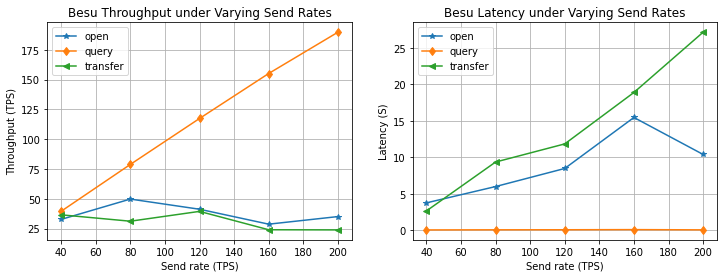

In [2]:
import matplotlib.pyplot as plt

openTPS = df_res[df_res.index=='open']['Throughput (TPS)'].values
queryTPS = df_res[df_res.index=='query']['Throughput (TPS)'].values
transferTPS = df_res[df_res.index=='transfer']['Throughput (TPS)'].values

openLatency = df_res[df_res.index=='open']['Avg Latency (s)'].values
queryLatency = df_res[df_res.index=='query']['Avg Latency (s)'].values
transferLatency = df_res[df_res.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].plot(sendrates, openTPS, label='open', marker='*')
axs[0].plot(sendrates, queryTPS, label='query', marker='d')
axs[0].plot(sendrates, transferTPS, label='transfer', marker='<')
axs[0].set(title='Besu Throughput under Varying Send Rates', 
    xlabel='Send rate (TPS)', ylabel='Throughput (TPS)')
axs[0].grid()
axs[0].legend()

axs[1].plot(sendrates, openLatency, label='open', marker='*')
axs[1].plot(sendrates, queryLatency, label='query', marker='d')
axs[1].plot(sendrates, transferLatency, label='transfer', marker='<')
axs[1].set(title='Besu Latency under Varying Send Rates', 
    xlabel='Send rate (TPS)', ylabel='Latency (S)')
axs[1].grid()
axs[1].legend()

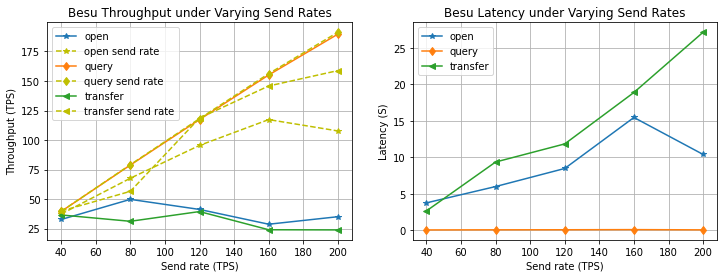

In [6]:
import matplotlib.pyplot as plt

openTPS = df_res[df_res.index=='open']['Throughput (TPS)'].values
openSendRate = df_res[df_res.index=='open']['Send Rate (TPS)'].values
queryTPS = df_res[df_res.index=='query']['Throughput (TPS)'].values
querySendRate = df_res[df_res.index=='query']['Send Rate (TPS)'].values
transferTPS = df_res[df_res.index=='transfer']['Throughput (TPS)'].values
transferSendRate = df_res[df_res.index=='transfer']['Send Rate (TPS)'].values

openLatency = df_res[df_res.index=='open']['Avg Latency (s)'].values
queryLatency = df_res[df_res.index=='query']['Avg Latency (s)'].values
transferLatency = df_res[df_res.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].plot(sendrates, openTPS, label='open', marker='*')
axs[0].plot(sendrates, openSendRate, 'y--', label='open send rate', marker='*')
axs[0].plot(sendrates, queryTPS, label='query', marker='d')
axs[0].plot(sendrates, querySendRate, 'y--', label='query send rate', marker='d')
axs[0].plot(sendrates, transferTPS, label='transfer', marker='<')
axs[0].plot(sendrates, transferSendRate, 'y--', label='transfer send rate', marker='<')
axs[0].set(title='Besu Throughput under Varying Send Rates', 
    xlabel='Send rate (TPS)', ylabel='Throughput (TPS)')
axs[0].grid()
axs[0].legend()

axs[1].plot(sendrates, openLatency, label='open', marker='*')
axs[1].plot(sendrates, queryLatency, label='query', marker='d')
axs[1].plot(sendrates, transferLatency, label='transfer', marker='<')
axs[1].set(title='Besu Latency under Varying Send Rates', 
    xlabel='Send rate (TPS)', ylabel='Latency (S)')
axs[1].grid()
axs[1].legend()